In [1]:
import pandas as pd
import numpy as np
import xarray as xr

import os
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from src.helpers import *
from src.visualize import *
from src.trainer import *
from Models.models import *
from Models.SimpleRNN_NC import SimpleRNN_NC

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import *
from copy import deepcopy
import torch.utils.data as data
from torch.utils.data import Dataset

import pickle
import math

/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#@title Helper functions for plotting (run this cell!)
sns.set_context("notebook")

# initialize a color palette for plotting
palette = sns.xkcd_palette(["windows blue",
                            "red",
                            "medium green",
                            "dusty purple",
                            "orange",
                            "amber",
                            "clay",
                            "pink",
                            "greyish"])

In [3]:
# Helper function to convert between numpy arrays and tensors
to_t = lambda array: torch.tensor(array, device='cpu', dtype=dtype)  #device
to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
from_t = lambda tensor: tensor.to("cpu").detach().numpy()

## Load data

In [4]:
data_path = './Data/Processed_Data/Tidy_Sansa_13_04.pkl'

with open(data_path, 'rb') as file:
    df = pickle.load(file)

In [5]:
baseline_df = df.loc[df.type == 'BASELINE'].reset_index()

In [6]:
stim_df = df.loc[df.type == 'TONIC'].reset_index()

## Try Simple RNN

In [7]:
X_train, y_train, X_val, y_val, X_test, y_test, info_train, info_val, info_test = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [130]:
# Test one of the folds first
fold_num = 'fold0'
fold = 0

print('We are testing the optimization method on fold ', fold)

seq_length = 75
X_train = X_train[fold_num]
X_val = X_val[fold_num]
X_test = X_test[fold_num]
y_test = y_test[fold_num]
y_train = y_train[fold_num]
y_val = y_val[fold_num]

# Reshape x_train to match the number of columns in the model's input layer
xx_train = X_train.reshape(X_train.shape[0] // seq_length, seq_length, X_train.shape[1])  
# Reshape y_train to match the number of neurons in the model's output layer
yy_train = y_train.reshape(y_train.shape[0] // seq_length, seq_length, y_train.shape[1])  

xx_val = X_val.reshape(X_val.shape[0] // seq_length, seq_length, X_val.shape[1])  
yy_val = y_val.reshape(y_val.shape[0] // seq_length, seq_length, y_val.shape[1])  

xx_test = X_test.reshape(X_test.shape[0] // seq_length, seq_length, X_test.shape[1])  
yy_test = y_test.reshape(y_test.shape[0] // seq_length, seq_length, y_test.shape[1])  



We are testing the optimization method on fold  0


In [131]:
# Define hyperparameters

# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train.shape[1]
num_features = X_train.shape[1]

seed = 42
torch.manual_seed(seed)

seq_length = 75

#Hyperparameters objective and regularization
alpha_reg = 1e-7
l1_ratio_reg = 0.394

lr = 0.0001 # 0.00193
loss_function = huber_loss
delta = 7  # hyperparameter for huber loss

# Hyperparameters LSTM class
hidden_units = 11
#num_layers = 1
#input_size = 31 Not for now, only if I need a linear layer before the RNN

#Other training hyperparameters
lr_gamma= 1.437 #for scheduler
lr_step_size = 10 #for scheduler


input_rec = 40
seq_length_LSTM = 16


batch_size_train= 30
batch_size_val = 30

**RNN Parameters**

input_size – The number of expected features in the input x

hidden_size – The number of features in the hidden state h

num_layers – Number of recurrent layers. E.g., setting num_layers=2 would mean stacking two RNNs together to form a stacked RNN, with the second RNN taking in outputs of the first RNN and computing the final results. Default: 1

nonlinearity – The non-linearity to use. Can be either 'tanh' or 'relu'. Default: 'tanh'

bias – If False, then the layer does not use bias weights b_ih and b_hh. Default: True

batch_first – If True, then the input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature). Note that this does not apply to hidden or cell states. See the Inputs/Outputs sections below for details. Default: False

dropout – If non-zero, introduces a Dropout layer on the outputs of each RNN layer except the last layer, with dropout probability equal to dropout. Default: 0

bidirectional – If True, becomes a bidirectional RNN. Default: False

In [145]:
model = CausalTemporalLSTM(num_features= num_features, hidden_units = hidden_units,
                            num_layers= 1, input_size = input_rec,out_dims=num_dim_output,  
                            dropout_1= 0.2, dropout_2= 0.4).to(device)

In [146]:
[i.shape for i in list(model.parameters())]

[torch.Size([88, 51]),
 torch.Size([88, 22]),
 torch.Size([88]),
 torch.Size([88]),
 torch.Size([51, 127]),
 torch.Size([51]),
 torch.Size([3, 22]),
 torch.Size([3])]

In [28]:
""" from hypnettorch.mnets import SimpleRNN


model = SimpleRNN_NC(n_in=num_features, rnn_layers=(hidden_units,hidden_units,hidden_units), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = False, dropout=0.1).to(device)  """
#Here we use no_weights = False to try to train the model only on baseline data

' from hypnettorch.mnets import SimpleRNN\n\n\nmodel = SimpleRNN_NC(n_in=num_features, rnn_layers=(hidden_units,hidden_units,hidden_units), \n                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),\n                use_lstm = True, no_weights = False, dropout=0.1).to(device)  '

In [29]:
xx_train = to_t(xx_train)
yy_train = to_t(yy_train)
xx_val = to_t(xx_val)
yy_val = to_t(yy_val)

In [30]:
train_losses, val_losses = \
    train_model(model, xx_train,yy_train,
                xx_val, 
                yy_val,
                lr= lr,
                lr_step_size=lr_step_size,
                lr_gamma= lr_gamma,
                sequence_length_LSTM=seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                delta = 8,                 
                regularizer= Regularizer_LSTM,
                l1_ratio = l1_ratio_reg,
                alpha = alpha_reg, # CAREFUL WITH INTEGERS
                early_stop = 5,
                
                )

/home/nerea/CL_UpperLimb_Control/src/trainer.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.X = torch.tensor(X)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:148: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y)
/home/nerea/CL_UpperLimb_Control/src/trainer.py:149: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.cl

Epoch 000 Train 0.0351 Val 0.0346
Epoch 001 Train 0.0346 Val 0.0348
Epoch 002 Train 0.0341 Val 0.0350
Epoch 003 Train 0.0334 Val 0.0347
Epoch 004 Train 0.0323 Val 0.0341
Epoch 005 Train 0.0304 Val 0.0322
Epoch 006 Train 0.0276 Val 0.0301
Epoch 007 Train 0.0249 Val 0.0284
Epoch 008 Train 0.0229 Val 0.0275
Epoch 009 Train 0.0214 Val 0.0265
Epoch 010 Train 0.0201 Val 0.0257
Epoch 011 Train 0.0189 Val 0.0254
Epoch 012 Train 0.0178 Val 0.0255
Epoch 013 Train 0.0171 Val 0.0254
Epoch 014 Train 0.0163 Val 0.0247
Epoch 015 Train 0.0159 Val 0.0234
Epoch 016 Train 0.0154 Val 0.0227
Epoch 017 Train 0.0149 Val 0.0221
Epoch 018 Train 0.0146 Val 0.0230
Epoch 019 Train 0.0142 Val 0.0230
Epoch 020 Train 0.0136 Val 0.0218
Epoch 021 Train 0.0128 Val 0.0213
Epoch 022 Train 0.0121 Val 0.0210
Epoch 023 Train 0.0115 Val 0.0214
Epoch 024 Train 0.0111 Val 0.0211
Epoch 025 Train 0.0107 Val 0.0208
Epoch 026 Train 0.0104 Val 0.0211
Epoch 027 Train 0.0101 Val 0.0205
Epoch 028 Train 0.0098 Val 0.0201
Epoch 029 Trai

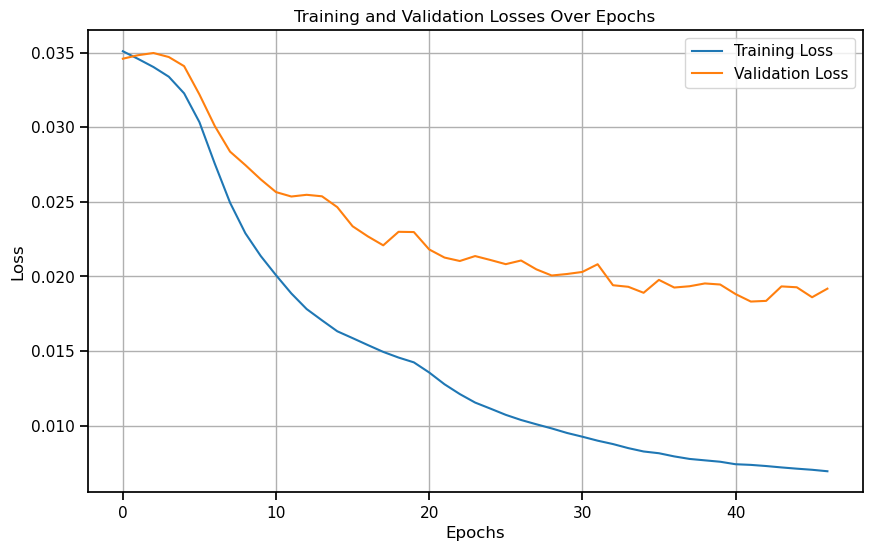

In [32]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [33]:
 # Move the test stimulus and measured rates to the GPU
xx_train = to_t_eval(xx_train)
yy_train = to_t_eval(yy_train)
xx_val = to_t_eval(xx_val)
yy_val = to_t_eval(yy_val)
xx_test = to_t_eval(xx_test)
yy_test = to_t_eval(yy_test)


/tmp/ipykernel_417379/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_417379/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_417379/815769189.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  to_t_eval =  lambda array: torch.tensor(array, device='cuda', dtype=dtype)  #device
/tmp/ipykernel_417379/815769189.py:3: Us

In [34]:
y_pred = model(xx_val)
y_array = yy_val.detach().cpu().numpy()
y_pred_array = y_pred.detach().cpu().numpy()

# Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
y_true_2D = y_array.reshape(-1, y_array.shape[-1])

In [35]:
y_hat, y_true, train_score, v_score, test_score = eval_model(xx_train, yy_train, xx_val, yy_val, xx_test, yy_test, model, metric = 'ev')

Train EV: 0.84 
Val EV: 0.60 
Test EV: 0.28 


## CL with Hypernetworks

First we define the BASELINE and STIMULATION datasets for CL.

In [8]:
X_train_b, y_train_b, X_val_b, y_val_b, X_test_b, y_test_b, info_train_b, info_val_b, info_test_b = train_test_split(baseline_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  4
Val trials 3


In [9]:
X_train_s, y_train_s, X_val_s, y_val_s, X_test_s, y_test_s, info_train_s, info_val_s, info_test_s = train_test_split(stim_df, train_variable = 'both_rates', 
                                                                                                   target_variable = 'target_pos', num_folds = 5)

Test trials  8
Val trials 7


In [10]:
# Test one of the folds first
fold_num = 'fold1'
fold = 1

print('We are testing the optimization method on fold ', fold)

def input_mats(x,y, seq_length = 75):
    x = x[fold_num]
    y = y[fold_num]
    x = x.reshape(x.shape[0] // seq_length, seq_length, x.shape[1])  
    y = y.reshape(y.shape[0] // seq_length, seq_length, y.shape[1])  
    return x,y

x_train_base, y_train_base = input_mats(X_train_b, y_train_b)
x_train_stim, y_train_stim = input_mats(X_train_s, y_train_s)

x_val_base, y_val_base = input_mats(X_val_b, y_val_b)
x_val_stim, y_val_stim = input_mats(X_val_s, y_val_s)

x_test_base, y_test_base = input_mats(X_test_b, y_test_b)
x_test_stim, y_test_stim = input_mats(X_test_s, y_test_s)

seed = 42
torch.manual_seed(seed)

We are testing the optimization method on fold  1


Tutorial on the use of the hypnettorch package: https://github.com/chrhenning/hypnettorch/blob/master/hypnettorch/tutorials/getting_started.ipynb


From hypnettorch, we have:

- `SimpleRNN:` model which works as main networks and which has already the option or passing weights generated by other network in the forward loop.
    
- `HMLP:` A variety of hypernetworks is available in subpackage hypnettorch.hnets. The simplest being a fully-connected hypernetwork, see class hypnettorch.hnets.HMLP. Such simplistic hypernetwork is huge, as its parameter count is quadratic in the number of parameters of the corresponding main network. Therefore, several more sophisticated hypernetwork options are available, which are just as simple to use (most notably, hypnettorch.hnets.ChunkedHMLP). However, to keep this tutorial light, we don't discuss these options here.

In [11]:
from IPython.display import display, Markdown, Latex

In [12]:
# Specify that we want our tensors on the GPU and in float32
device = torch.device('cuda:0') #suposed to be cuda
dtype = torch.float32
path_to_models = './Models'

num_dim_output = y_train_stim.shape[2]
num_features = x_train_stim.shape[2]

seed = 42
torch.manual_seed(seed)

seq_length = 75

#### From Optuna: for an explained variance of 0.495 in the validation set (using simple_RNN, not my version)

Best hyperparameters: 

{'hidden_units': 22, 'input_rec': 51, 

'seq_length_LSTM': 10, 'size_task_embedding': 19,

 'num_units_hnet': 27, 'num_layers_hnet': 3, 

 'lr': 0.004320940130391012, 'lr_gamma': 1.2255870196855894, 

 'huber_delta': 8, 'alpha_reg': 0.00036710979427904543, 
 
 'l1_ratio_reg': 0.6953641537406922, 'batch_size': 20}

In [16]:
from hypnettorch.mnets import SimpleRNN

hidden_units = 22
input_rec = 51
seq_length_LSTM = 10


model = SimpleRNN_NC(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = False, no_weights = True, 
                dropout = 0.5).to(device)  

# Here no_weight set to true for the model to take the weights generated with the hypernetwork

Creating a simple RNN with 8753 weights.


In [17]:
model.param_shapes

[[51, 127], [51], [22, 51], [22], [22, 22], [22], [22, 22], [22], [3, 22], [3]]

In [18]:
model.param_shapes_meta

[{'name': 'weight', 'index': -1, 'layer': 1},
 {'name': 'bias', 'index': -1, 'layer': 1},
 {'name': 'weight', 'index': -1, 'layer': 3, 'info': 'ih'},
 {'name': 'bias', 'index': -1, 'layer': 3, 'info': 'ih'},
 {'name': 'weight', 'index': -1, 'layer': 3, 'info': 'hh'},
 {'name': 'bias', 'index': -1, 'layer': 3, 'info': 'hh'},
 {'name': 'weight', 'index': -1, 'layer': 3, 'info': 'ho'},
 {'name': 'bias', 'index': -1, 'layer': 3, 'info': 'ho'},
 {'name': 'weight', 'index': -1, 'layer': 5},
 {'name': 'bias', 'index': -1, 'layer': 5}]

Hypernetworks usually distinguish between two types of inputs: *conditional* and *unconditional* inputs. Conditional inputs are simply inputs that can be related to a finite and discrete set of conditions, such as the [task identity in continual learning](https://arxiv.org/abs/1906.00695). Simply speaking, conditional inputs can be used if the number $N$ of conditions is known a priori. In this case, the hypernetwork will create a set of $N$ learnable condition vectors (e.g., task embeddings), and can take the condition ID (as integer) as input to the ``forward`` method. This simplifies many usage scenarios, as the user of a hypernetwork does not have to maintain learnable input embeddings to the hypernetwork by himself. In all other cases (like the input to the hypernetwork comes from a continuous vector space), *unconditional* inputs should be used.

In our case, the hypernetwork should either generate a set of weights for MNIST (condition $0$) or FashionMNIST (condition $1$). Each of these conditions should internally be represented by a $8$-dimensional embedding vector.

In [153]:
model.param_shapes

[[51, 127], [51], [88, 51], [88], [88, 22], [88], [3, 22], [3]]

In [154]:
[torch.Size([88, 51]),
 torch.Size([88, 22]),
 torch.Size([88]),
 torch.Size([88]),
 torch.Size([51, 127]),
 torch.Size([51]),
 torch.Size([3, 22]),
 torch.Size([3])]

[torch.Size([88, 51]),
 torch.Size([88, 22]),
 torch.Size([88]),
 torch.Size([88]),
 torch.Size([51, 127]),
 torch.Size([51]),
 torch.Size([3, 22]),
 torch.Size([3])]

In [155]:
from hypnettorch.hnets import HMLP

num_conditions = 2
size_task_embedding = 19

hnet = HMLP(model.param_shapes, uncond_in_size=0,
             cond_in_size=size_task_embedding,
            layers=[27], 
            num_cond_embs=num_conditions).to(device)

print()
print('The randomly initialized input embeddings are:\n', 
      hnet.conditional_params)

Created MLP Hypernet.
Hypernetwork with 370094 weights and 13197 outputs (compression ratio: 28.04).
The network consists of 370056 unconditional weights (370056 internally maintained) and 38 conditional weights (38 internally maintained).

The randomly initialized input embeddings are:
 [Parameter containing:
tensor([ 1.9269,  1.4873,  0.9007,  0.4396, -0.7581,  1.0783,  0.8008,  1.6806,
         0.3559, -0.6866, -0.4934,  1.3347, -0.2316,  0.0418, -0.2516,  0.8599,
        -0.3097, -0.3957,  0.8034], device='cuda:0', requires_grad=True), Parameter containing:
tensor([ 1.7174,  0.3189, -0.4245, -0.8140, -0.7360, -0.8371, -0.9224,  1.8113,
         0.1606,  0.3672,  0.1754, -1.1845,  1.3835, -1.2024,  0.7078, -1.0759,
         0.5357,  1.1754,  0.5612], device='cuda:0', requires_grad=True)]


**Hypernetwork initialization** 
can be an important factor, for instance, [when using optimizers such as SGD](https://openreview.net/forum?id=H1lma24tPB). 

Therefore, some hypernet implementations provide custom initialization functions.

In [156]:
hnet.apply_hyperfan_init(mnet=model)

**Making predictions** with the target network is fairly easy. Simply generate the corresponding weights with the hypernetwork and pass them to the ``forward`` method of the main network together with the network inputs. 

In [157]:
from torch.utils.data import Dataset

In [158]:
# Define parameters for training
lr = 0.004
num_epochs = 1000
batch_size_train = 20
batch_size_val = 20
alpha_reg = 0.00037
l1_ratio_reg = 0.69
lr_gamma = 1.22
huber_delta = 8


In [159]:
print(reg_hnet)

<function reg_hnet at 0x7f6a6ade1940>


In [160]:
train_losses, val_losses, W_base, W_stim = train_hypernet(
                model, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=lr,
                lr_step_size=10,
                lr_gamma=lr_gamma,
                sequence_length_LSTM= seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=num_epochs, 
                regularizer = reg_hnet_noweights, 
                l1_ratio = l1_ratio_reg,
                delta = huber_delta,  
                alpha = alpha_reg,   )

Epoch 000 Train 0.0281 Val 0.0402
Epoch 001 Train 0.0173 Val 0.0394
Epoch 002 Train 0.0135 Val 0.0431
Epoch 003 Train 0.0113 Val 0.0431
Epoch 004 Train 0.0103 Val 0.0483
Epoch 005 Train 0.0098 Val 0.0428
Epoch 006 Train 0.0092 Val 0.0420
Epoch 007 Train 0.0088 Val 0.0453
Epoch 008 Train 0.0085 Val 0.0395
Epoch 009 Train 0.0083 Val 0.0447
Epoch 010 Train 0.0082 Val 0.0470
Epoch 011 Train 0.0082 Val 0.0449
Epoch 012 Train 0.0080 Val 0.0455
Epoch 013 Train 0.0080 Val 0.0457
Epoch 014 Train 0.0078 Val 0.0434
Decrease LR
Epoch 015 Train 0.0076 Val 0.0472
Epoch 016 Train 0.0074 Val 0.0455
Epoch 017 Train 0.0071 Val 0.0461
Epoch 018 Train 0.0070 Val 0.0468
Epoch 019 Train 0.0069 Val 0.0489
Decrease LR


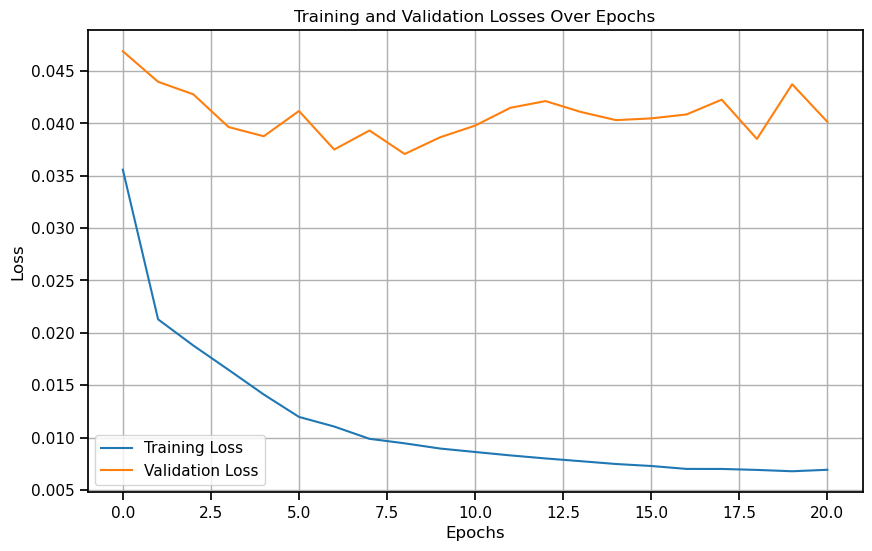

In [112]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [113]:
def calc_explained_variance(x, y, mnet, mnet_weights):
    """Compute the explained variance for a given dataset"""
    with torch.no_grad():
        # Process complete dataset as one batch.
        # Convert X_train and y_train to PyTorch tensors
        inputs = torch.tensor(x, device=device, dtype=torch.float32)
        targets = torch.tensor(y, device=device, dtype=torch.float32)

        # Forward pass to get predictions
        predictions = mnet(inputs, weights=mnet_weights)

        y_array = targets.detach().cpu().numpy()
        y_pred_array = predictions.detach().cpu().numpy()
     
        # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
        y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
        y_true_2D = y_array.reshape(-1, y_array.shape[-1])

        # Compute explained variance
        explained_var = explained_variance_score(y_true_2D, y_pred_2D)

    return explained_var

In [114]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [115]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, model, W_base)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  0.9514476855595907
Explained variance for  Validation  is :  0.4476320544878642
Explained variance for  Test  is :  0.3602500756581624


In [116]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, model, W_stim)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  0.9298517306645712
Explained variance for  Validation  is :  0.4483947555224101
Explained variance for  Test  is :  0.480570912361145


In [117]:
def reshape_to_eval_hnet(x,y, model, weights):
    x = to_t_eval(x) 
    y = to_t_eval(y)
    y_pred = model(x, weights = weights)
    y_array = y.detach().cpu().numpy()
    y_pred_array = y_pred.detach().cpu().numpy()

    # Reshape tensors to 2D arrays (flatten the batch and sequence dimensions)
    y_pred_2D = y_pred_array.reshape(-1, y_pred_array.shape[-1])
    y_true_2D = y_array.reshape(-1, y_array.shape[-1])
    
    return y_true_2D, y_pred_2D

In [118]:
y_true_2D, y_pred_2D = reshape_to_eval_hnet (x_test_base, y_test_base, model, W_base)

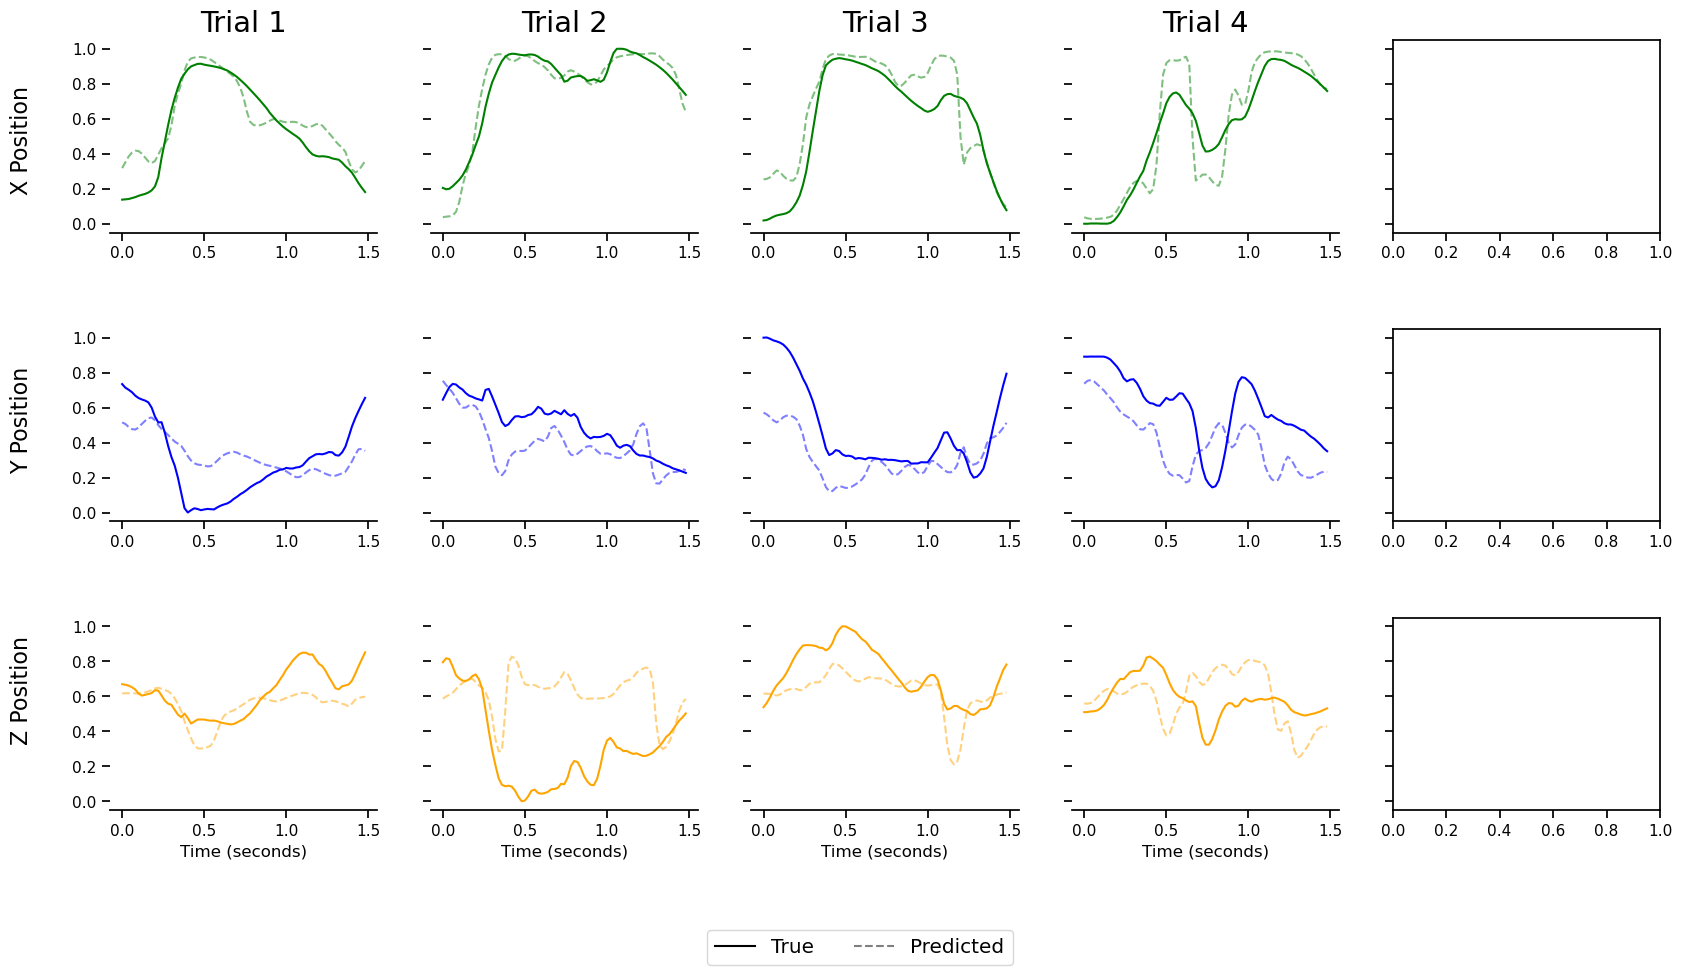

In [119]:
visualize_LSTM_test(y_pred_2D, y_true_2D, seq_length = 75)

## Trying hypernetworks in chunks

This tutorial shows how to utilize a StructuredHMLP (a certain kind of hypernetwork that allows smart chunking) in combination with a ResNet.

In [79]:
from hypnettorch.hnets.chunked_mlp_hnet import ChunkedHMLP

In [80]:
net = SimpleRNN(n_in=num_features, rnn_layers=(hidden_units,), 
                  fc_layers_pre=(input_rec,), fc_layers=(num_dim_output,),
                use_lstm = True, no_weights = True).to(device) 

Creating a simple RNN with 12223 weights.


In [81]:
chunk_size = 1000
num_tasks = 2

In [82]:
hnet = ChunkedHMLP(net.param_shapes, chunk_size = chunk_size, chunk_emb_size=8, 
cond_chunk_embs=True, uncond_in_size=0, cond_in_size=12, layers=(40, 40), 
 num_cond_embs=num_tasks).to(device) 

Created Chunked MLP Hypernet with 13 chunk(s) of size 1000.
Hypernetwork with 43712 weights and 12223 outputs (compression ratio: 3.58).
The network consists of 43480 unconditional weights (43480 internally maintained) and 232 conditional weights (232 internally maintained).


In [83]:
train_losses, val_losses, W_base, W_stim = train_hypernet(
        net, hnet, y_train_base, x_train_base,
                y_train_stim,  x_train_stim,
                y_val_base,  x_val_base,
                y_val_stim,    x_val_stim,
                lr=0.001,
                lr_step_size=10,
                lr_gamma=0.9,
                sequence_length_LSTM= seq_length_LSTM,
                batch_size_train = batch_size_train,
                batch_size_val = batch_size_val,
                num_epochs=1000, 
                regularizer = reg_hnet_noweights, 
                l1_ratio = 0.5,
                alpha = 1e-3, 
                chunks = True  )

Initializing hypernet with Chunked Hyperfan Init ...


/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/hypnettorch/hnets/chunked_mlp_hnet.py:793: UserWarning: Note, hypernetwork inputs should have an initial total variance (std) smaller than 0.026247 (0.162008) in order for this method to work properly.
  warn('Note, hypernetwork inputs should have an initial total ' +
/home/nerea/anaconda3/envs/sinthlab/lib/python3.8/site-packages/hypnettorch/hnets/chunked_mlp_hnet.py:812: UserWarning: Initial variance of 13/13 chunk embeddings had to be clipped.
  warn('Initial variance of %d/%d ' % (n_clipped, len(chunk_vars)) + \


Epoch 000 Train 1.8580 Val 0.2447
Epoch 001 Train 0.1224 Val 0.0985
Epoch 002 Train 0.0685 Val 0.0761
Epoch 003 Train 0.0552 Val 0.0711
Epoch 004 Train 0.0464 Val 0.0654
Epoch 005 Train 0.0415 Val 0.0622
Epoch 006 Train 0.0379 Val 0.0570
Epoch 007 Train 0.0359 Val 0.0573
Epoch 008 Train 0.0339 Val 0.0571
Epoch 009 Train 0.0321 Val 0.0552
Epoch 010 Train 0.0306 Val 0.0516
Epoch 011 Train 0.0288 Val 0.0516
Epoch 012 Train 0.0274 Val 0.0515
Epoch 013 Train 0.0264 Val 0.0526
Epoch 014 Train 0.0252 Val 0.0507
Epoch 015 Train 0.0245 Val 0.0500
Epoch 016 Train 0.0235 Val 0.0496
Epoch 017 Train 0.0223 Val 0.0494
Epoch 018 Train 0.0211 Val 0.0467
Epoch 019 Train 0.0201 Val 0.0492
Epoch 020 Train 0.0192 Val 0.0498
Epoch 021 Train 0.0190 Val 0.0496
Epoch 022 Train 0.0182 Val 0.0506
Decrease LR
Epoch 023 Train 0.0176 Val 0.0477
Epoch 024 Train 0.0171 Val 0.0469
Epoch 025 Train 0.0167 Val 0.0495
Epoch 026 Train 0.0163 Val 0.0473
Epoch 027 Train 0.0158 Val 0.0493
Decrease LR


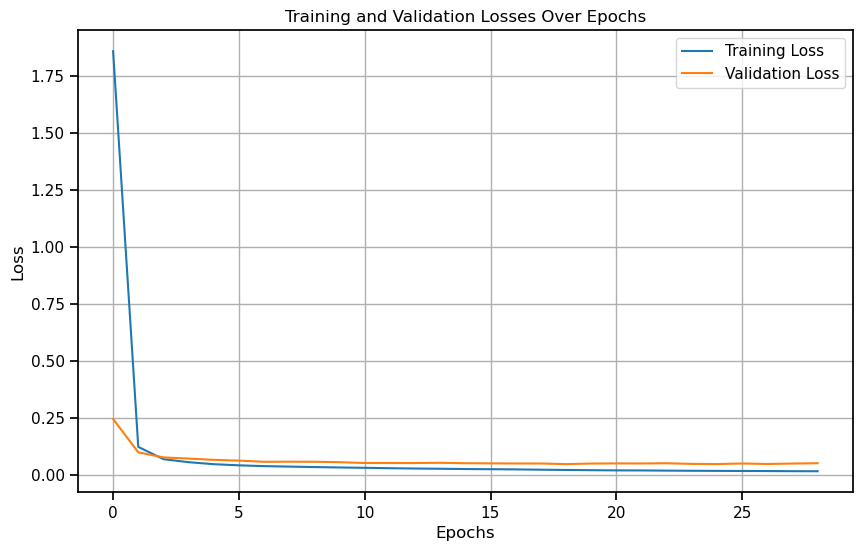

In [84]:
# Assuming you have already trained your model and collected the losses
# train_losses and val_losses are numpy arrays containing losses for each epoch
plot_losses(train_losses, val_losses)

In [85]:
subsets = ['Training', 'Validation', 'Test']

data_base = [[x_train_base, y_train_base],
             [x_val_base, y_val_base],
             [x_test_base, y_test_base]]

data_stim = [[x_train_stim, y_train_stim],
             [x_val_stim, y_val_stim],
             [x_test_stim, y_test_stim]]

In [86]:
for index, [x,y] in enumerate(data_base):
    ev = calc_explained_variance(x, y, net, W_base)
    print('Explained variance for ', subsets[index], ' is : ', ev)


Explained variance for  Training  is :  0.5903700391451517
Explained variance for  Validation  is :  0.495531698067983
Explained variance for  Test  is :  0.4317145148913066


In [87]:
for index, [x,y] in enumerate(data_stim):
    ev = calc_explained_variance(x, y, net, W_stim)
    print('Explained variance for ', subsets[index], ' is : ', ev)

Explained variance for  Training  is :  0.6629307866096497
Explained variance for  Validation  is :  0.3053845961888631
Explained variance for  Test  is :  0.1252118945121765
